#### load data


In [ ]:
import keras
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.madry_et_al import madry_et_al
from cleverhans.tf2.attacks.spsa import spsa
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2



import tensorflow as tf
import cleverhans
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from time import process_time

from helper.helper import *
from methods.deepfool import *
from methods.randomfuzz import *
from methods.pixelfuzz import * 

# loading the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3) 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# expand the input size by 3*3, so the input now is 64*64
X_train = np.repeat(X_train,3,axis=1)
X_train = np.repeat(X_train,3,axis=2)
X_test = np.repeat(X_test,3,axis=1)
X_test = np.repeat(X_test,3,axis=2)

In [ ]:

# load the model only loads the model itself, this model is used to compare the 
# time consumption not transferability, no need to compute transfer rate. 
# Transfer_count and transfer adv_count are set 1 and 0 to just as a placeholder 
model = keras.models.load_model("./Models/simple_cnn_expanded3.h5")
transfer_count = 1
transfer_adv_count = 0

# some constants
num_adversarials = 50
results = dict()
# set the stepsize
epsilon = 1/255

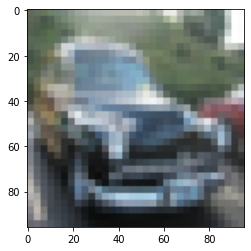

In [ ]:
# Compute the 
logits_model = tf.keras.Model(model.input,model.layers[-1].output)
seed_images = []
seed_labels = []
i = 0
while i < (num_adversarials):
    random_index = np.random.randint(X_test.shape[0])
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape(1,X_test.shape[1],X_test.shape[2],3), dtype=float) 
    original_label = y_test[random_index]
    predict_X = np.argmax(model.predict(original_image))
    if (predict_X == original_label):
        seed_images.append(original_image)
        seed_labels.append(predict_X)
        i+=1
plt.figure()
plt.grid(False)
image = seed_images[-1]
plt.imshow(np.reshape(image, (image.shape[1],image.shape[2],3)))
plt.show()

#### 1. DeepFool

In [ ]:
# test the Deepfool
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)

for i in  range(num_adversarials):
    now = process_time()
    r, loop_i, label_orig, label_pert, adv_image = deepfool(seed_images[i], model,shape=(96, 96, 3))
    adv_image = np.clip(adv_image,0,1)
    times[i] += process_time()-now
    prediction = np.argmax(model.predict(adv_image))
    distance[i] = float(tf.norm(seed_images[i] - adv_image, ord=2))

results["deepfool"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 6.583661856828257
average runtime 0.1265625


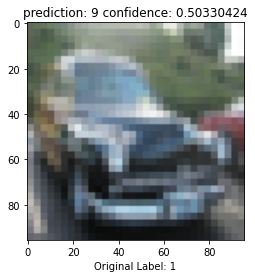

In [ ]:
print("average distance", np.sum(results['deepfool'][1])/len(results['deepfool'][1]))
print("average runtime", np.sum(results['deepfool'][2])/len(results['deepfool'][2]))
draw(model,adv_image,seed_labels[-1])

#### 2. FGSM

In [ ]:
# test the FGSM
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = fast_gradient_method(logits_model,  image, epsilon*50, norm=2, targeted=False, clip_max=1, clip_min = 0)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["fgsm"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 0.3307305708527565
average runtime 0.0159375


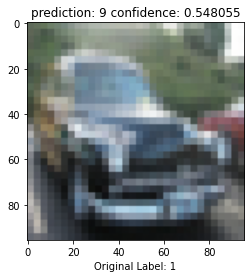

In [ ]:
print("average distance", np.sum(results['fgsm'][1])/len(results['fgsm'][1]))
print("average runtime", np.sum(results['fgsm'][2])/len(results['fgsm'][2]))
draw(model,adv_image,seed_labels[-1])

#### 3. BIM

In [ ]:
# test the BIM
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = basic_iterative_method(logits_model, image, eps = epsilon*50,eps_iter=epsilon,nb_iter=50, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["bim"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.3050635915994644
average runtime 0.23375


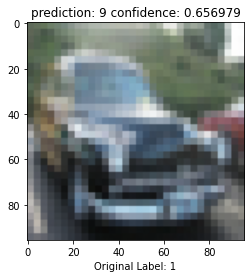

In [ ]:
print("average distance", np.sum(results['bim'][1])/len(results['bim'][1]))
print("average runtime", np.sum(results['bim'][2])/len(results['bim'][2]))
draw(model,adv_image,seed_labels[-1])

#### 4.madry

In [ ]:
# test the madry, which is projected_gradient_descent with special
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = madry_et_al(logits_model, image, eps = epsilon*50,eps_iter=epsilon,nb_iter=50, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["madry"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.33136970311403274
average runtime 0.2765625


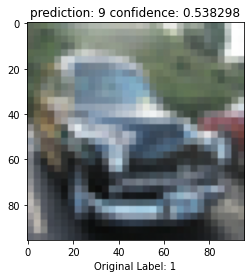

In [ ]:
print("average distance", np.sum(results['madry'][1])/len(results['madry'][1]))
print("average runtime", np.sum(results['madry'][2])/len(results['madry'][2]))
draw(model,adv_image,seed_labels[-1])

#### 5. random fuzz

In [ ]:
# test the random fuzzer
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    now = process_time()
    while(1):
        adv_image = random_fuzz(image, epsilon*5)
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            d = float(tf.norm(seed_images[i] - image, ord=2))
            times[i]+=process_time()-now
            distance [i] = d
            break
results["randomfuzz"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 11.530244317054748
average runtime 4.8709375


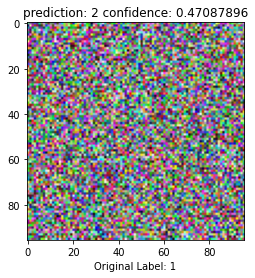

In [ ]:
print("average distance", np.sum(results['randomfuzz'][1])/len(results['randomfuzz'][1]))
print("average runtime", np.sum(results['randomfuzz'][2])/len(results['randomfuzz'][2]))
draw(model,adv_image,seed_labels[-1])

#### 6. MIM (momentum iterative method)

In [ ]:
# test the MIM, which is projected_gradient_descent with special
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = momentum_iterative_method(logits_model, image, norm=2, clip_max=1, clip_min = 0,sanity_checks=False)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["MIM"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.3822287321090698
average runtime 0.0465625


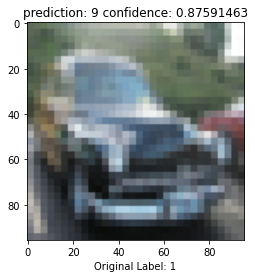

In [ ]:
print("average distance", np.sum(results['MIM'][1])/len(results['MIM'][1]))
print("average runtime", np.sum(results['MIM'][2])/len(results['MIM'][2]))
draw(model,adv_image,seed_labels[-1])

#### 7. SPSA

In [ ]:
# SPSA
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = spsa(logits_model, image, seed_labels[i],epsilon, 50, clip_max=1, clip_min = 0)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
results["SPSA"] = (transfer_adv_count/ transfer_count, distance, times)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


c:\users\victiny\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


average distance 0.9076695716381074
average runtime 4.2959375


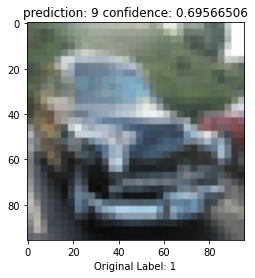

In [ ]:
print("average distance", np.sum(results['SPSA'][1])/len(results['SPSA'][1]))
print("average runtime", np.sum(results['SPSA'][2])/len(results['SPSA'][2]))
draw(model,adv_image,seed_labels[-1])

#### 8. Carlini Wagner

In [ ]:
# carlini wagner
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    while(1):
        now = process_time()
        adv_image = carlini_wagner_l2(logits_model, image)
        times[i]+=process_time()-now
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            distance[i] = float(tf.norm(seed_images[i] - image, ord=2))
            break
        print("1")
results["CW"] = (transfer_adv_count/ transfer_count, distance, times)


average distance 0.25195290327072145
average runtime 26.3378125


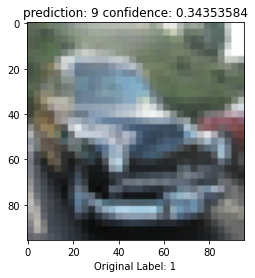

In [ ]:
print("average distance", np.sum(results['CW'][1])/len(results['CW'][1]))
print("average runtime", np.sum(results['CW'][2])/len(results['CW'][2]))
draw(model,adv_image,seed_labels[-1])

#### 9. Pixel fuzz

In [ ]:
times = np.zeros(num_adversarials)
distance = np.zeros(num_adversarials)
for i in  range (num_adversarials):
    image = seed_images[i]
    now = process_time()
    while(1):
        adv_image = pixel_fuzz(logits_model, image, epsilon*5, num_pixels = 10)
        prediction = np.argmax(model.predict(adv_image))
        # replace the image with the generated adversarial image
        image = adv_image
        if prediction != seed_labels[i]:
            d = float(tf.norm(seed_images[i] - image, ord=2))
            if d<=1.5:
                times[i]+=process_time()-now
                distance [i] = d
                break
results["pixelfuzz"] = (transfer_adv_count/ transfer_count, distance, times)

average distance 0.739250255599618
average runtime 2.3415625


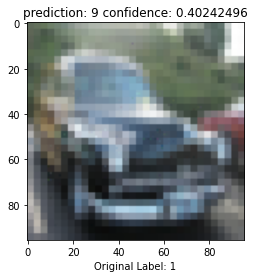

In [ ]:
print("average distance", np.sum(results['pixelfuzz'][1])/len(results['pixelfuzz'][1]))
print("average runtime", np.sum(results['pixelfuzz'][2])/len(results['pixelfuzz'][2]))
draw(model,adv_image,seed_labels[-1])

#### show model architecture


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 75)        2100      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 75)        300       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 50)        33800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 50)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 50)        22550     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 50)        2

In [ ]:
save_obj(results,"simplecnnexpanded3stats")